# Anomaly Detection
(by Tevfik Aytekin)

In [ ]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

### A Simple Problem to Get Started
Given the following data points in 2D, which points are anomalies (or outliers)? Try to think of an algorithm. 

In [ ]:
X, y = make_blobs(n_samples=100, n_features=2, cluster_std=1,centers=[[0, 0], [0, 0]], random_state=1)
rand = np.random.RandomState(1)
n_outliers=10
X = np.concatenate([X, rand.uniform(low=-5, high=5,size=(n_outliers, 2))], axis=0)

plt.scatter(X[:,0], X[:,1])
plt.axis([-10, 10, -10, 10])
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
print(X)

In [ ]:
n = X.shape[0]
n_conts = int(n*0.1)
n_conts

In [ ]:
means = np.mean(X, axis=0)
d = X - means
euc = np.sqrt(np.sum(d*d, axis=1))
s = np.argsort(euc)
euc[s[n-n_conts]] 

In [ ]:
# Detects anomaly points by calculating the euclidian distance to centroids.
class euclidian:
    def __init__(self, contamination = 0.1):
        self.contamination = contamination
        
    def fit(self, X):
        n = X.shape[0]
        n_conts = int(n*self.contamination)
        self.means = np.mean(X, axis=0)
        d = X - self.means
        euc = np.sqrt(np.sum(d*d, axis=1))
        s = np.argsort(euc)
        self.cutoff_dist = euc[s[n-n_conts]] 
        
    def predict(self, X):
        d = X - self.means
        euc = np.sqrt(np.sum(d*d, axis=1))
        for i in range(len(euc)):
            if (euc[i] > self.cutoff_dist):
                euc[i] = 1
            else:
                euc[i] = -1
        
        return euc

In [ ]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 50),
                     np.linspace(-10, 10, 50))
alg = euclidian(contamination=0.1)
alg.fit(X)
Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X[:,0], X[:,1])
plt.axis([-10, 10, -10, 10])
plt.gca().set_aspect('equal', adjustable='box')

#### A Problem with this approach

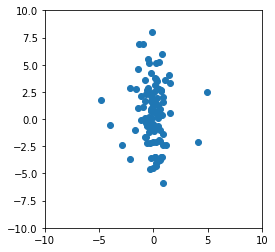

In [110]:
mean = [0, 0]
cov = [[0.5, 0], [0, 10]]  # diagonal covariance
np.random.seed(1)
x, y = np.random.multivariate_normal(mean, cov, 100).T
X = np.c_[x, y]
n_outliers=10
X = np.concatenate([X, rand.uniform(low=-5, high=5,size=(n_outliers, 2))], axis=0)

plt.scatter(X[:,0], X[:,1])
plt.axis([-10, 10, -10, 10])
plt.gca().set_aspect('equal', adjustable='box')

Since this algorithm builds a spherical decision boundary and since the data is not spherically distributed, there are both false positives and false negatives as the following figrue illustrates.

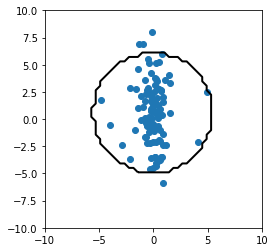

In [111]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 50),
                     np.linspace(-10, 10, 50))
alg = euclidian(contamination=0.05)
alg.fit(X)
Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X[:,0], X[:,1])
plt.axis([-10, 10, -10, 10])
plt.gca().set_aspect('equal', adjustable='box')

### Solution
The solution is to normalize the spread along each dimension.

In [112]:
class euclidian_normalized:
    def __init__(self, contamination = 0.1):
        self.contamination = contamination
        
    def fit(self, X):
        n = X.shape[0]
        n_conts = int(n*self.contamination)
        self.vars = np.var(X, axis=0)
        self.means = np.mean(X, axis=0)
        d = (X / np.sqrt(self.vars)) - self.means
        euc = np.sqrt(np.sum(d*d, axis=1))
        s = np.argsort(euc)
        self.cutoff_dist = euc[s[n-n_conts]] 
        
    def predict(self, X):
        d = (X / np.sqrt(self.vars)) - self.means
        euc = np.sqrt(np.sum(d*d, axis=1))
        for i in range(len(euc)):
            if (euc[i] > self.cutoff_dist):
                euc[i] = 1
            else:
                euc[i] = -1
        
        return euc

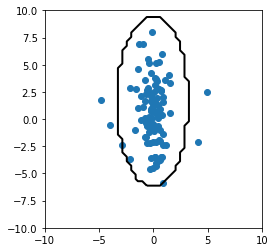

In [113]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 50),
                     np.linspace(-10, 10, 50))
alg = euclidian_normalized(contamination=0.05)
alg.fit(X)
Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X[:,0], X[:,1])
plt.axis([-10, 10, -10, 10])
plt.gca().set_aspect('equal', adjustable='box')

You can also take a probabilistic approach

In [114]:
class probabilistic:
    def __init__(self, contamination = 0.1):
        self.contamination = contamination
        
    def fit(self, X):
        self.means = np.mean(X, axis=0)
        self.vars = np.var(X, axis=0)
        # Convert values into probabilities
        probs_X = X.copy()
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                probs_X[i,j] = scipy.stats.norm(self.means[j], np.sqrt(self.vars[j])).pdf(X[i,j])
        probs = np.prod(probs_X, axis=1)
        n = len(probs)
        n_conts = int(n*self.contamination)
        s = np.argsort(probs)
        self.cutoff_prob = probs[s[n_conts]] 
        
    def predict(self, X):
        probs_X = X.copy()
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                probs_X[i,j] = scipy.stats.norm(self.means[j], np.sqrt(self.vars[j])).pdf(X[i,j])
        probs = np.prod(probs_X, axis=1)
        for i in range(len(probs)):
            if (probs[i] > self.cutoff_prob):
                probs[i] = 1
            else:
                probs[i] = -1
        return probs

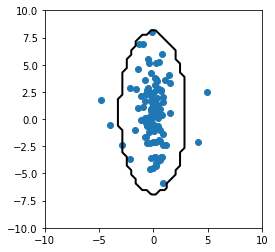

In [115]:
xx, yy = np.meshgrid(np.linspace(-10, 10, 50),
                     np.linspace(-10, 10, 50))
alg = probabilistic(contamination=0.05)
alg.fit(X)
Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X[:,0], X[:,1])
plt.axis([-10, 10, -10, 10])
plt.gca().set_aspect('equal', adjustable='box')

### Another Problem

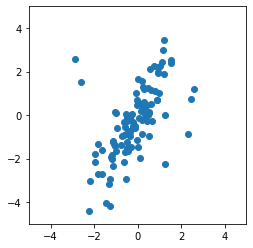

In [129]:
mean = [0, 0]
cov = [[1, 1.5], [1.5, 3]]  # diagonal covariance
np.random.seed(1)
x, y = np.random.multivariate_normal(mean, cov, 100).T
X = np.c_[x, y]
n_outliers=10
X = np.concatenate([X, rand.uniform(low=-3, high=3,size=(n_outliers, 2))], axis=0)
plt.scatter(X[:,0], X[:,1])
plt.axis([-5, 5, -5, 5])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


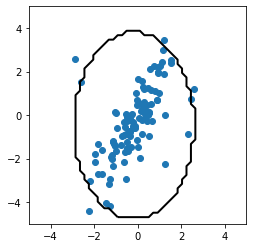

In [130]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50),
                     np.linspace(-5, 5, 50))
alg = euclidian_normalized(contamination=0.05)
alg.fit(X)
Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X[:,0], X[:,1])
plt.axis([-5, 5, -5, 5])
plt.gca().set_aspect('equal', adjustable='box')

### The solution is to use Mahalanobis Distance

The Mahalanobis distance of a point $x=(x_{1},x_{2},x_{3},\dots ,x_{N})^{T}$ from a set of points with mean $\mu =(\mu _{1},\mu _{2},\mu _{3},\dots ,\mu _{N})^{T}$ and covariance matrix $S$ is defined as

$$
 D(x) = \sqrt{(x - \mu )^T {S}^{-1} (x - \mu) }
$$

In [159]:
class mahalanobis:
    def __init__(self, contamination = 0.1):
        self.contamination = contamination
        
    def fit(self, X):
        n = X.shape[0]
        n_conts = int(n*self.contamination)
        self.means = np.mean(X, axis=0)
        
        cov = np.cov(X.T)
        self.inv_cov = np.linalg.inv(cov)
        x_minus_mean = X - self.means
        d = np.dot(np.dot(x_minus_mean, self.inv_cov), x_minus_mean.T)
        d=np.sqrt(d.diagonal())
        s = np.argsort(d)
        self.cutoff_dist = euc[s[n-n_conts]] 
        
    def predict(self, X):
        x_minus_mean = X - self.means
        d = np.dot(np.dot(x_minus_mean, self.inv_cov), x_minus_mean.T)
        d = np.sqrt(d.diagonal().copy())
        for i in range(len(d)):
            if (d[i] > self.cutoff_dist):
                d[i] = 1
            else:
                d[i] = -1
        
        return d

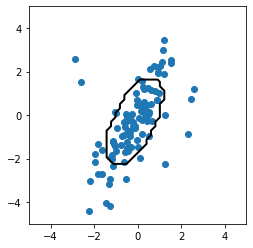

In [160]:
xx, yy = np.meshgrid(np.linspace(-5, 5, 50),
                     np.linspace(-5, 5, 50))
alg = mahalanobis(contamination=0.1)
alg.fit(X)
Z = alg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
plt.scatter(X[:,0], X[:,1])
plt.axis([-5, 5, -5, 5])
plt.gca().set_aspect('equal', adjustable='box')